# Value SARSA

> CRLD SARSA agents in value space  

The value-based SARSA dynamics have been developed and used in the paper, [Intrinsic fluctuations of reinforcement learning promote cooperation](https://www.nature.com/articles/s41598-023-27672-7) by Barfuss W, Meylahn J in Sci Rep 13, 1309 (2023).

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()

In [ ]:
#| default_exp Agents/ValueSARSA

In [ ]:
#| hide
# Imports for the nbdev development environment
from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

## Example

First, we import the necessary libraries.


In [ ]:
from pyCRLD.Agents.ValueSARSA import valSARSA
from pyCRLD.Agents.ValueBase import multiagent_epsilongreedy_strategy

from pyCRLD.Environments.SocialDilemma import SocialDilemma

import numpy as np
import matplotlib.pyplot as plt

Next, we define an epsilon-greedy strategy function. This strategy function selects the best action with probability 1-epsilon and a random action with probability epsilon.

In [ ]:
epsgreedy = multiagent_epsilongreedy_strategy(epsilon_greedys=[0.01, 0.01])

We define the environment to be a simple stag-hunt game.

In [ ]:
env = SocialDilemma(R=1.0, T=0.75, S=-0.15, P=0.0)

We use both, the strategy function and the envrionment to create the value-based SARSA multi-agent environment objecte `mae`

In [ ]:
mae = valSARSA(env, discount_factors=0.5, learning_rates=0.1, strategy_function=epsgreedy)

We illustrate the value-based SARSA agents by sampling from 50 random initial values and plot the resulting learning times series in value space.

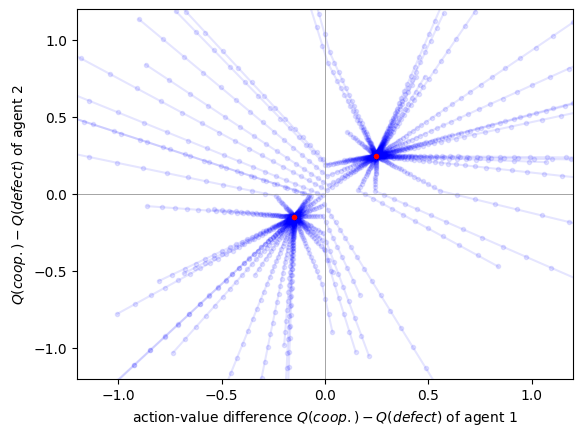

In [ ]:
for _ in range(50):
        Qinit = mae.random_values()
        Qtisa, fpr = mae.trajectory(Qinit, Tmax=1000, tolerance=10e-9)

        # plot time series
        plt.plot(Qtisa[:, 0, 0, 0]- Qtisa[:, 0, 0, 1], 
                Qtisa[:, 1, 0, 0]- Qtisa[:, 1, 0, 1],
                '.-', alpha=0.1, color='blue')
        # plot last point
        plt.plot(Qtisa[-1, 0, 0, 0]- Qtisa[-1, 0, 0, 1],
                Qtisa[-1, 1, 0, 0]- Qtisa[-1, 1, 0, 1],
                '.', color='red')

# plot quadrants
plt.plot([0, 0], [-2, 2], '-', color='gray', lw=0.5)
plt.plot([-2, 2], [0, 0], '-', color='gray', lw=0.5)

plt.xlim(-1.2, 1.2); plt.ylim(-1.2, 1.2)
plt.xlabel(r'action-value difference $Q(coop.) - Q(defect)$ of agent 1'); 
plt.ylabel(r'$Q(coop.) - Q(defect)$ of agent 2');

## Implementation

In [ ]:
#| export
import numpy as np
import itertools as it
from functools import partial

import jax
from jax import jit
import jax.numpy as jnp

from fastcore.utils import *

from pyCRLD.Agents.ValueBase import valuebase
from pyCRLD.Utils.Helpers import *

In [ ]:
#| export   
class valSARSA(valuebase):
    """
    Class for CRLD-SARSA agents in value space.
    """

The temporal difference reward-prediction error is calculated as follows:

In [ ]:
#| export
@partial(jit, static_argnums=(0,2))
def RPEisa(self:valSARSA,
           Qisa,  # Joint strategy
           norm=False # normalize error around actions? 
           ) -> np.ndarray:  # reward-prediction error
    """
    Compute temporal-difference reward-prediction error for 
    value SARSA dynamics, given joint state-action values `Qisa`.
    """
    Risa = self.valRisa(Qisa)
    NextQisa = self.value_NextQisa(Qisa)
    
    n = jnp.newaxis
    E = self.pre[:,n,n]*Risa + self.gamma[:,n,n]*NextQisa - Qisa
    
    E = E - E.mean(axis=2, keepdims=True) if norm else E
    return E
valSARSA.RPEisa = RPEisa

In [ ]:
#| export
@partial(jit, static_argnums=0)
def valRisa(self:valSARSA, 
            Qisa): # Joint state-action values
    """ Average reward Risa, given joint state-action values `Qisa` """
    Xisa = self.strategy_function.action_probabilities(Qisa)
    Risa = self.Risa(Xisa)
    return Risa
valSARSA.valRisa = valRisa

In [ ]:
#| export
@partial(jit, static_argnums=0)
def valNextQisa(self:valSARSA, 
                Qisa):   
    """
    Compute strategy-average next state-action value for agent `i`, current
    state `s` and action `a`, given joint state-action values `Qisa`.
    """
    Xisa = self.strategy_function.action_probabilities(Qisa)
    valQisa = self.Qisa(Xisa)  # true state-action values given current Qisa

    i = 0  # agent i
    a = 1  # its action a
    s = 2  # the current state
    sprim = 3  # the next state
    j2k = list(range(4, 4+self.N-1))  # other agents
    b2d = list(range(4+self.N-1, 4+self.N-1 + self.N))  # all actions
    e2f = list(range(3+2*self.N, 3+2*self.N + self.N-1))  # all other acts

    sumsis = [[j2k[l], s, e2f[l]] for l in range(self.N-1)]  # sum inds
    otherX = list(it.chain(*zip((self.N-1)*[Xisa], sumsis)))
        
    NextQisa = jnp.einsum(valQisa, [i, s, a], Xisa, [i, s, a], [i, s])
                
    args = [self.Omega, [i]+j2k+[a]+b2d+e2f] + otherX +\
        [self.T, [s]+b2d+[sprim], NextQisa, [i, sprim], [i, s, a]]
    return jnp.einsum(*args, optimize=self.opti)
valSARSA.value_NextQisa = valNextQisa  

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()